In [1]:
import pandas
import feather
import datetime
import numpy
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.ticker import FuncFormatter, MaxNLocator
from davitpy.models import *
from davitpy import utils
from aacgmv2 import convert_mlt
%matplotlib inline

In [2]:
sizeAsyCutoff = 50.

In [3]:
# We need to combine the potential model with
# the SAPS location model to limit the data
# to locations where we see SAPS
def saps_pred_func(x, y, dstInp):
#     (a_sx, b_sx, a_sy, b_sy, a_xo, b_xo, a_yo, b_yo, a_o, b_o, theta) = \
#         ( 2.93, 2.67e-3, 2.21, 3e-3, 3.86, 6.03e-2, -0.51, 5.57e-2, 0.985, 0.93e-3, 0.633 )
    a_sx = 3.11
    b_sx = 0.00371
    a_sy = 1.72
    b_sy = 0.000819
    a_xo = 4.59
    b_xo = 0.0633
    a_yo = -1.19
    b_yo = 0.0321
    a_o = 0.893
    b_o = -0.00147
    theta = 0.692
    # parameters from fitting
#     (a_sx, b_sx, a_sy, b_sy, a_xo, b_xo, a_yo, b_yo, a_o, b_o, theta) = \
#         ( 2.58, -0.007, 1.03, -0.023, 3.99,  \
#            0.041, -1.63, 0.02, 1.11, 0.006, 0.68 )
    sigma_x = a_sx + b_sx * dstInp
    sigma_y = a_sy + b_sy * dstInp
    xo = a_xo + b_xo * dstInp
    yo = a_yo + b_yo * dstInp
    amplitude = a_o + b_o * dstInp    
    
    a = (numpy.cos(theta)**2)/(2*sigma_x**2) + (numpy.sin(theta)**2)/(2*sigma_y**2)
    b = -(numpy.sin(2*theta))/(4*sigma_x**2) + (numpy.sin(2*theta))/(4*sigma_y**2)
    c = (numpy.sin(theta)**2)/(2*sigma_x**2) + (numpy.cos(theta)**2)/(2*sigma_y**2)
    outProb = amplitude*numpy.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return outProb

### build test dst indices and plot them
sapsPredDF = pandas.DataFrame(columns=["normMLT", "normLAT", "probSAPS", "MLT", "Lat", "dst_index"])
latArr = []
mltArr = []
normLatArr = []
normMltArr = []
probSapsArr = []
dstArr = []
dstIndSel = [ -120., -100., -75., -50, -25., -5. ,0. ]
for z in dstIndSel:
    for x in range( -7, 8 ):
        for y in range( -12, 10 ):        
            normLatArr.append( x )
            normMltArr.append( y )
            dstArr.append( z )
            if y > 0:
                mltArr.append( y )
            else:
                mltArr.append( y + 24 )
            latArr.append( x + 57. )
            probSapsArr.append( saps_pred_func(x,y,z) )
        
sapsPredDF["MLT"] = mltArr
sapsPredDF["Lat"] = latArr
sapsPredDF["normMLT"] = normMltArr
sapsPredDF["normLAT"] = normLatArr
sapsPredDF["probSAPS"] = probSapsArr
sapsPredDF["dst_index"] = dstArr
# Limit SAPS location to where prob > 0.2
sapsPredDF = sapsPredDF[ sapsPredDF["probSAPS"] >= 0.05\
                       ].reset_index(drop=True)
sapsPredDF.head()

,normMLT,normLAT,probSAPS,MLT,Lat,dst_index
0,-6,-7,0.089514,18,50.0,-120.0
1,-5,-7,0.162988,19,50.0,-120.0
2,-4,-7,0.223678,20,50.0,-120.0
3,-3,-7,0.231361,21,50.0,-120.0
4,-2,-7,0.180367,22,50.0,-120.0


In [4]:
potDF = feather.read_dataframe('../data/potDF.feather')
potDF.head()

,AsyH,MLAT,normMLT,potential,normLAT,potMagn,mlt
0,45.0,56.5,-7.0,-2.21,-2.0,2.21,17.0
1,45.0,57.0,-7.0,-3.82,-1.5,3.82,17.0
2,45.0,57.5,-7.0,-5.75,-1.0,5.75,17.0
3,45.0,58.5,-7.0,-7.77,0.0,7.77,17.0
4,45.0,59.0,-7.0,-10.10,0.5,10.10,17.0


In [5]:
# Get number of values for different Asy Inds
# discard those values which have low counts
sizeAsyDF = potDF.groupby("AsyH").size().reset_index()
sizeAsyDF.columns = [ "AsyH", "asyCnt" ]
sizeAsyDF = sizeAsyDF[ sizeAsyDF["asyCnt"] >= sizeAsyCutoff]
potDF = pandas.merge(potDF, sizeAsyDF,\
                     on = "AsyH", how="inner"\
                    ).reset_index(drop=True)
# Get peak potentials
peakPotDF = potDF[[ "AsyH", "potMagn" ]].groupby( "AsyH" ).max().reset_index()
peakPotDF.columns = [ "AsyH", "peakPotMagn" ]

In [6]:
# We'll model peak potential as a log function of AsyH index.
def peak_pot_fit_func( (asy), a_asy, b_asy):
    peakPotVal = a_asy + b_asy*numpy.log(asy)    
    return peakPotVal

poptPeakPot, pcovPeakPot = curve_fit(peak_pot_fit_func,\
                               (peakPotDF['AsyH'].T),\
                               peakPotDF['peakPotMagn'], p0=(1, 0.1))

print list(poptPeakPot)

print "Vpeak = ", str( round(poptPeakPot[0],2) ), "+", str( round(poptPeakPot[1],2) ), "x log(AsyH-index)"

print "-----Error details-----"
print numpy.sqrt(numpy.diag(pcovPeakPot))
print "-----Error details-----"

# get pred peak potentials
peakPotDF["predPeakPot"] = [ peak_pot_fit_func(x, *poptPeakPot) for x in peakPotDF["AsyH"] ]

# Normalize the values of potential
# for every AsyH value. This makes 
# fitting easy!
potDF = pandas.merge( potDF, peakPotDF, on="AsyH" )
potDF["normPot"] = potDF["potMagn"]/potDF["peakPotMagn"]

[-6.465832985211851, 9.479420990561056]
Vpeak =  -6.47 + 9.48 x log(AsyH-index)
-----Error details-----
[1.92873521 0.48303875]
-----Error details-----


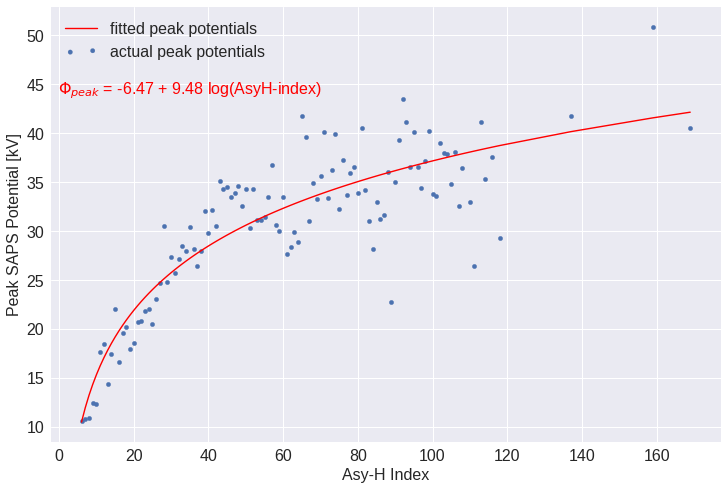

In [7]:
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)

sns.set_style("whitegrid")
sns.set_context("paper")

peakPotDF.plot( x="AsyH", y="peakPotMagn", kind="scatter", ax=ax, label="actual peak potentials" )
peakPotDF.plot( x="AsyH", y="predPeakPot", c="r", ax=ax, label="fitted peak potentials" )

printText = "$\Phi_{peak}$ = " +\
            str( round(poptPeakPot[0],2) ) +\
            " + " + str( round(poptPeakPot[1],2) ) +\
            " log(AsyH-index)"

ax.text(0.01, 0.8,  printText,
            transform=ax.transAxes,
            color='red', fontsize=16)

ax.set_xlabel("Asy-H Index", fontsize=16)
ax.set_ylabel("Peak SAPS Potential [kV]", fontsize=16)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16, loc=2, scatterpoints=2)

f.savefig( "../figs/potMagFit.eps",bbox_inches='tight' )

In [8]:
# divide data into bins
asyHBins = [ 0, 30, 60, 90, 180 ]
potDF = pandas.concat( [ potDF, \
                    pandas.cut( potDF["AsyH"], \
                               bins=asyHBins ) ], axis=1 )
potDF.columns = [ "AsyH", "MLAT", "normMLT", "potential",\
                 "normLAT", "potMagn", "mlt", "asyCnt",\
                 "peakPotMagn", "predPeakPot", "normPot", "AsyH-bin" ]

In [9]:
# To estimate the boundary we
# fit second order harmonics!
def mlt_fit_func((mlt, asy), c1_a, c1_b, s1_a, s1_b,\
                 c2_a, c2_b, s2_a, s2_b, phiC0):
    # Setup the base constants 
    # as functions of Asy index
    c1 = c1_a + c1_b*asy
    s1 = s1_a + s1_b*asy
    c2 = c2_a + c2_b*asy
    s2 = s2_a + s2_b*asy
    phi0 = (2*numpy.pi/24.) * mlt + phiC0
    cosTerm = c1 * numpy.cos(phi0)
    sinTerm = s1 * numpy.sin(phi0)
    cos2Term = c2 * numpy.cos(2*phi0)
    sin2Term = s2 * numpy.sin(2*phi0)
    return cosTerm + sinTerm + cos2Term + sin2Term

In [29]:
potDF["AsyHRnd"] = numpy.round(potDF["AsyH"]/30.)*30.
mltPotDF = potDF[ ["AsyHRnd", "normMLT", "normPot", "mlt", "AsyH-bin"]\
                ].groupby( ["AsyHRnd", "normMLT", "mlt"] \
                ).max().reset_index()
mltPotDF = mltPotDF.dropna()


poptNormPot, pcovNormPot = curve_fit(mlt_fit_func,\
                               (mltPotDF['mlt'].T, mltPotDF['AsyHRnd'].T),\
                               mltPotDF['normPot'], p0=(1., 1., 1., 1., 1., 1.,\
                                                          1., 1., 1.))
print poptNormPot
poptNormPot = [ round(x,4) for x in poptNormPot ]
print poptNormPot
print "-----Error details-----"
print numpy.sqrt(numpy.diag(pcovNormPot))
print "-----Error details-----"
predAsyArr = []
predMltArr = []
predNormMltArr = []
predPotArr = []
poptPotArr = []
testInpAsy = 23.
for currAsy in ( numpy.append( mltPotDF["AsyHRnd"].unique() , testInpAsy) ):
    for cpMlt in range(24):
        predMltArr.append( cpMlt )
        predAsyArr.append( currAsy )
        # Fit params
        predPotArr.append( mlt_fit_func(\
                                    (cpMlt, currAsy), *poptNormPot) )
        poptPotArr.append( poptNormPot )
        if cpMlt > 12.:
            normMlt = cpMlt - 24.
        else:
            normMlt = cpMlt
        predNormMltArr.append( normMlt )
    
predPotDF = pandas.DataFrame({
                "predPot" : predPotArr,
                "predMLT" : predMltArr,
                "predNormMLT" : predNormMltArr,
                "predAsy" : predAsyArr,
                "poptPot" : poptPotArr
                })

predPotDF = predPotDF.sort_values("predNormMLT")

[-7.35286023e-01  2.70479047e-03  1.02620533e+00 -2.33929360e-03
  9.10357918e-02 -2.26419837e-03  1.03579421e-01  1.63902905e-03
 -3.48009265e+00]
[-0.7353, 0.0027, 1.0262, -0.0023, 0.091, -0.0023, 0.1036, 0.0016, -3.4801]
-----Error details-----
[1150654.26618711    2622.98192455  824454.83989465    3032.80289896
  232281.16837134    3675.59180411  204151.59589734    5077.55970258
 1121270.98343888]
-----Error details-----


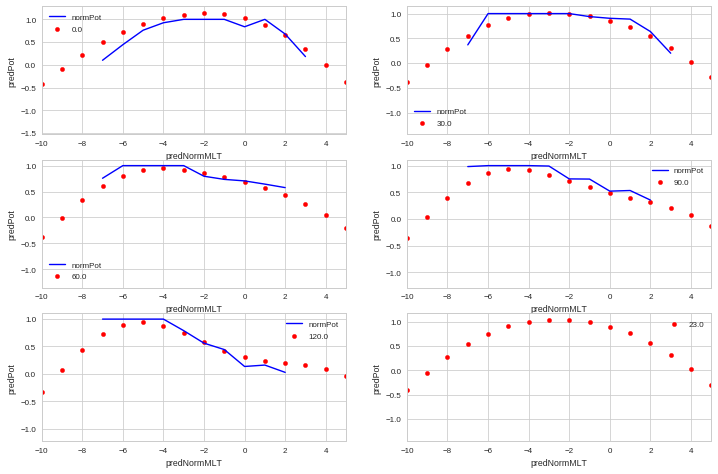

In [11]:
# asyList = [ 0., 40., 80., 120., 160. ]
asyList = [ 0., 30., 60., 90., 120. ]
f = plt.figure(figsize=(12, 8))
ax = []
ax.append( f.add_subplot(3,2,1) )
ax.append( f.add_subplot(3,2,2) )
ax.append( f.add_subplot(3,2,3) )
ax.append( f.add_subplot(3,2,4) )
ax.append( f.add_subplot(3,2,5) )
ax.append( f.add_subplot(3,2,6) )
seaMap = ListedColormap(sns.color_palette("Reds"))


for pltInd, pltAsy in enumerate( asyList + [testInpAsy] ):
    pltDF = mltPotDF[ (mltPotDF["AsyHRnd"] == pltAsy) ]
    if pltDF.shape[0] > 0.:
        pltDF.plot( x='normMLT',
                    y='normPot', ax=ax[pltInd], c='b')

    pltPredDF = predPotDF[ (predPotDF["predAsy"] == pltAsy) ]
    pltPredDF.plot( x='predNormMLT',
                  y='predPot',ax=ax[pltInd], kind="scatter", c= 'r', label=str(pltAsy))
    ax[pltInd].set_xlim( [-10, 5] )

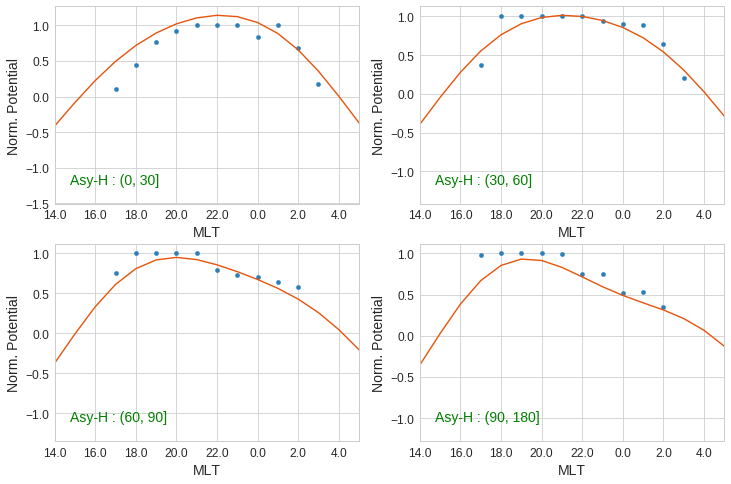

In [12]:
def format_mlt_normMLT_ticks(tick_val, tick_pos):
    if tick_val < 0:
        return str(tick_val + 24)
    else:
        return str(tick_val)

# asyList = [ 0., 40., 80., 120. ]
asyList = [ 0., 30., 60., 90. ]
f = plt.figure(figsize=(12, 8))
ax = []
ax.append( f.add_subplot(2,2,1) )
ax.append( f.add_subplot(2,2,2) )
ax.append( f.add_subplot(2,2,3) )
ax.append( f.add_subplot(2,2,4) )
seaMap = ListedColormap(sns.color_palette("Reds"))


for pltInd, pltAsy in enumerate( asyList ):
    pltDF = mltPotDF[ (mltPotDF["AsyHRnd"] == pltAsy) ]
    if pltDF.shape[0] > 0.:
        pltDF.plot( x='normMLT',
                    y='normPot', ax=ax[pltInd], c='#2c7fb8', kind="scatter", label="")

    pltPredDF = predPotDF[ (predPotDF["predAsy"] == pltAsy) ]
    pltPredDF.plot( x='predNormMLT',
                  y='predPot',ax=ax[pltInd], kind="line", c= '#e6550d', label="")
    ax[pltInd].set_xlim( [-10, 5] )
#     ax[pltInd].set_ylim( [-2., 2.] )
#     print pltDF["AsyH-bin"].values[0], type(str(pltDF["AsyH-bin"].values[0]))
    ax[pltInd].text(0.05, 0.1,  "Asy-H : " + str(pltDF["AsyH-bin"].values[0]),
            transform=ax[pltInd].transAxes,
            color='green', fontsize=14)
    ax[pltInd].tick_params(labelsize=12)
    ax[pltInd].set_ylabel("Norm. Potential", fontsize=14)
    ax[pltInd].set_xlabel("MLT", fontsize=14)
    ax[pltInd].xaxis.set_major_formatter(FuncFormatter(format_mlt_normMLT_ticks))
#     ax[pltInd].legend(prop={'size': 12})
    ax[pltInd].legend_.remove()
plt.savefig("../figs/Pot-MLT-model.eps",bbox_inches='tight')

In [13]:
print pltPredDF

                                              poptPot  predAsy  predMLT  \
85  [-0.7353, 0.0027, 1.0262, -0.0023, 0.091, -0.0...     90.0       13   
86  [-0.7353, 0.0027, 1.0262, -0.0023, 0.091, -0.0...     90.0       14   
87  [-0.7353, 0.0027, 1.0262, -0.0023, 0.091, -0.0...     90.0       15   
88  [-0.7353, 0.0027, 1.0262, -0.0023, 0.091, -0.0...     90.0       16   
89  [-0.7353, 0.0027, 1.0262, -0.0023, 0.091, -0.0...     90.0       17   
90  [-0.7353, 0.0027, 1.0262, -0.0023, 0.091, -0.0...     90.0       18   
91  [-0.7353, 0.0027, 1.0262, -0.0023, 0.091, -0.0...     90.0       19   
92  [-0.7353, 0.0027, 1.0262, -0.0023, 0.091, -0.0...     90.0       20   
93  [-0.7353, 0.0027, 1.0262, -0.0023, 0.091, -0.0...     90.0       21   
94  [-0.7353, 0.0027, 1.0262, -0.0023, 0.091, -0.0...     90.0       22   
95  [-0.7353, 0.0027, 1.0262, -0.0023, 0.091, -0.0...     90.0       23   
72  [-0.7353, 0.0027, 1.0262, -0.0023, 0.091, -0.0...     90.0        0   
73  [-0.7353, 0.0027, 1.0

In [14]:
# To estimate MLAT variations we
# fit a polynomial function!
def mlat_fit_func((mlat, asy),\
            c0_a, c0_b, c1_a,\
            c1_b, c2):
    c0 = c0_a + c0_b * asy
    c1 = c1_a + c1_b * asy
#     c2 = c2_a + c2_b * asy
    return c0 + c1*mlat + c2*numpy.square(mlat)

In [15]:
mlatPotDF = potDF[ ["AsyHRnd", "normLAT", "normPot", "MLAT"]\
                ].groupby( ["AsyHRnd", "normLAT", "MLAT"] \
                ).mean().reset_index()

poptMLATPot, pcovMLATPot = curve_fit(mlat_fit_func,\
                               (mlatPotDF['MLAT'].T, mlatPotDF['AsyHRnd'].T),\
                               mlatPotDF['normPot'], p0=(1., 1., 1., 1., 1.))


poptMLATPot = [ round(x,5) for x in poptMLATPot ]
print list(poptMLATPot)

print "-----Error details-----"
print numpy.sqrt(numpy.diag(pcovMLATPot))
print "-----Error details-----"

predAsyArr = []
predMlatArr = []
predPotArr = []
poptPotArr = []

for currAsy in mlatPotDF["AsyHRnd"].unique():
    for cpMlat in range(53,65,1):
        predMlatArr.append( cpMlat )
        predAsyArr.append( currAsy )
        # Fit params
        predPotArr.append( mlat_fit_func(\
                                    (cpMlat, currAsy), *poptMLATPot) )
        poptPotArr.append( poptMLATPot )
        if cpMlt > 12.:
            normMlt = cpMlt - 24.
        else:
            normMlt = cpMlt
        predNormMltArr.append( normMlt )
    
predMLATPotDF = pandas.DataFrame({
                "predPot" : predPotArr,
                "predMLAT" : predMlatArr,
                "predAsy" : predAsyArr,
                "poptPot" : poptPotArr
                })

# print predMLATPotDF[ predMLATPotDF["predAsy"] == 40. ][ ["predPot", "predMLAT", "predAsy"] ]

[8.76578, -0.01102, -0.35977, 0.00021, 0.00366]
-----Error details-----
[2.78575844e+00 2.43276258e-03 9.39905308e-02 4.17710012e-05
 7.91341695e-04]
-----Error details-----


[  0.  30.  60.  90. 120. 150. 180.]


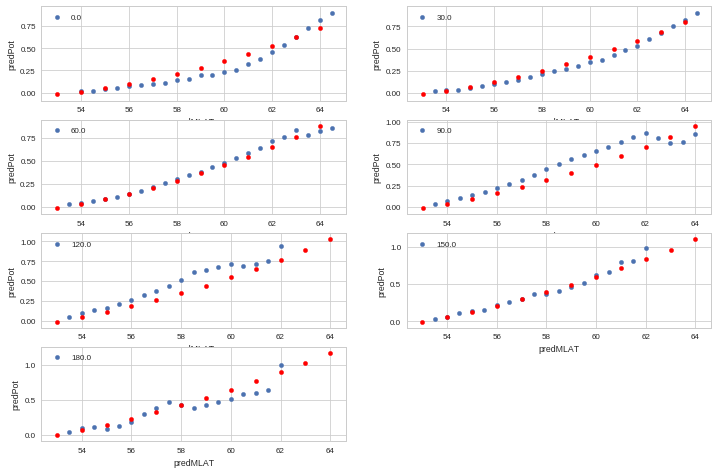

In [16]:
f = plt.figure(figsize=(12, 8))
# axm = f.add_subplot(1,1,1)
ax = []
ax.append( f.add_subplot(4,2,1) )
ax.append( f.add_subplot(4,2,2) )
ax.append( f.add_subplot(4,2,3) )
ax.append( f.add_subplot(4,2,4) )
ax.append( f.add_subplot(4,2,5) )
ax.append( f.add_subplot(4,2,6) )
ax.append( f.add_subplot(4,2,7) )
print mlatPotDF["AsyHRnd"].unique()
for cind, casy in enumerate( mlatPotDF["AsyHRnd"].unique() ):
    mlatPotDF[ mlatPotDF["AsyHRnd"] == casy\
             ].plot( x="MLAT", y="normPot", kind="scatter",\
                ax=ax[cind], label=str(casy) )
    subpredMLATPotDF = predMLATPotDF[ (predMLATPotDF["predAsy"] == casy) ]
    subpredMLATPotDF.plot( x='predMLAT',
                  y='predPot', c= 'r',ax=ax[cind], kind="scatter")

In [17]:
predAsyArr = []
predMlatArr = []
predPotArr = []
poptPotArr = []

for currAsy in range(0,151, 10):
    for cpMlat in range(50,65,1):
        predMlatArr.append( cpMlat )
        predAsyArr.append( currAsy )
        # Fit params
        predPotArr.append( mlat_fit_func(\
                                    (cpMlat, currAsy), *poptMLATPot) )
        poptPotArr.append( poptMLATPot )
        if cpMlt > 12.:
            normMlt = cpMlt - 24.
        else:
            normMlt = cpMlt
        predNormMltArr.append( normMlt )
    
testMLATPotDF = pandas.DataFrame({
                "predPot" : predPotArr,
                "predMLAT" : predMlatArr,
                "predAsy" : predAsyArr,
                "poptPot" : poptPotArr
                })

testMLATPotDF[ testMLATPotDF["predAsy"] == 120. ][ ["predPot", "predMLAT", "predAsy"] ]

,predPot,predMLAT,predAsy
180,-0.13512,50,120
181,-0.10003,51,120
182,-0.05762,52,120
183,-0.00789,53,120
184,0.04916,54,120
185,0.11353,55,120
186,0.18522,56,120
187,0.26423,57,120
188,0.35056,58,120
189,0.44421,59,120


In [18]:
# # To estimate the boundary we
# # fit second order harmonics!
# def mlt_fit_harmonic((mlt), c1, s1, c2, s2, phiC1, phiS1):
#     phiC = (2*numpy.pi/24.) * mlt + phiC1
#     phiS = (2*numpy.pi/24.) * mlt + phiS1
#     cosTerm = c1 * numpy.cos(phiC)
#     sinTerm = s1 * numpy.sin(phiS)
#     cos2Term = c2 * numpy.cos(2*phiC)
#     sin2Term = s2 * numpy.sin(2*phiS)
#     return cosTerm + sinTerm + cos2Term + sin2Term

In [19]:
# asyBinList = [ "(0, 30]", "(30, 60]", "(60, 90]", "(90, 180]" ]
# mltPotDF = potDF[ ["AsyH-bin", "normMLT", "normPot", "mlt"]\
#                 ].groupby( ["AsyH-bin", "normMLT", "mlt"] \
#                 ).max().reset_index()
# mltPotDF = mltPotDF.dropna()

# predAsyBinArr = []
# predMltArr = []
# predNormMltArr = []
# predPotArr = []
# poptPotArr = []

# for currAsyBin in asyBinList:
#     for cpMlt in range(25):
#         predMltArr.append( cpMlt )
#         predAsyBinArr.append( currAsyBin )
#         # Fit params
#         selSubMltDF = mltPotDF[ mltPotDF["AsyH-bin"] == currAsyBin ]
#         poptNormPot, pcovNormPot = curve_fit(mlt_fit_harmonic,\
#                                        (selSubMltDF['mlt'].T),\
#                                        selSubMltDF['normPot'], p0=(1., 1., 1., 1., 1., 1.))
# #         poptNormPot, pcovNormPot = curve_fit(mlt_fit_harmonic,\
# #                                                (selSubMltDF['mlt'].T),\
# #                                                selSubMltDF['normPot'], p0=(1.))
#         predPotArr.append( mlt_fit_harmonic(\
#                                     (cpMlt), *poptNormPot) )
#         poptPotArr.append( poptNormPot )
#         if cpMlt > 12.:
#             normMlt = cpMlt - 24.
#         else:
#             normMlt = cpMlt
#         predNormMltArr.append( normMlt )
    
# predPotDF = pandas.DataFrame({
#                 "predPot" : predPotArr,
#                 "predMLT" : predMltArr,
#                 "predNormMLT" : predNormMltArr,
#                 "predAsyBin" : predAsyBinArr,
#                 "poptPot" : poptPotArr
#                 })

In [20]:
# # get pred values
# predMltArr = []
# predNormMltArr = []
# predPotArr = []

# for cpMlt in range(25):
#     predMltArr.append( cpMlt )
#     predPotArr.append( mlt_fit_harmonic(\
#                                 (cpMlt), *poptNormPot) )
#     if cpMlt > 12.:
#         normMlt = cpMlt - 24.
#     else:
#         normMlt = cpMlt
#     predNormMltArr.append( normMlt )

# predPotDF = pandas.DataFrame({
#                 "predPot" : predPotArr,
#                 "predMLT" : predMltArr,
#                 "predNormMLT" : predNormMltArr
#                 })

In [21]:
# f = plt.figure(figsize=(12, 8))
# ax = []
# ax.append( f.add_subplot(2,2,1) )
# ax.append( f.add_subplot(2,2,2) )
# ax.append( f.add_subplot(2,2,3) )
# ax.append( f.add_subplot(2,2,4) )
# seaMap = ListedColormap(sns.color_palette("Reds"))


# for pltInd, pltAsyBin in enumerate( asyBinList ):
#     pltDF = mltPotDF[ (mltPotDF["AsyH-bin"] == pltAsyBin) ]
#     pltDF.plot( x='normMLT',
#                 y='normPot', ax=ax[pltInd], c='b', label=pltAsyBin)

#     pltPredDF = predPotDF[ (predPotDF["predAsyBin"] == pltAsyBin) ]
#     pltPredDF.plot( x='predNormMLT',
#                   y='predPot',ax=ax[pltInd], kind="scatter", c= 'r')
#     ax[pltInd].set_xlim( [-12, 12] )

In [22]:
# x0 = predPotDF[ predPotDF["predAsyBin"] == "(0, 30]" ]["poptPot"].values[0]
# x30 = predPotDF[ predPotDF["predAsyBin"] == "(30, 60]" ]["poptPot"].values[0]
# x60 = predPotDF[ predPotDF["predAsyBin"] == "(60, 90]" ]["poptPot"].values[0]
# x90 = predPotDF[ predPotDF["predAsyBin"] == "(90, 180]" ]["poptPot"].values[0]

In [23]:
# asyList = [ 0, 30, 60, 90 ]
# f = plt.figure(figsize=(12, 8))
# ax = []
# ax.append( f.add_subplot(3,2,1) )
# ax.append( f.add_subplot(3,2,2) )
# ax.append( f.add_subplot(3,2,3) )
# ax.append( f.add_subplot(3,2,4) )
# ax.append( f.add_subplot(3,2,5) )
# ax.append( f.add_subplot(3,2,6) )

# for pltParamInd, pltParam in enumerate( x0 ):
#     paramList = [ x0[pltParamInd], x30[pltParamInd], x60[pltParamInd], x90[pltParamInd] ]
#     ax[pltParamInd].plot( asyList, paramList, "r*", markersize=10., label=str(pltParamInd) )
#     ax[pltParamInd].legend()
# # f.savefig( "../figs/paramstest.pdf" )

In [24]:
# To estimate MLAT variations we
# fit a polynomial function!
def mlat_mlt_fit_func((mlat, normMLT, asy),\
            c0_a, c0_b, c0_c, c1_a,\
            c1_b, c1_c, c2):
    c0 = c0_a + c0_b * asy + c0_c*normMLT
    c1 = c1_a + c1_b * asy + c1_c*normMLT
#     c2 = c2_a + c2_b * asy
    return c0 + c1*mlat + c2*numpy.square(mlat)

In [30]:
mlatMLTPotDF = potDF[ ["AsyHRnd", "normMLT", "normPot", "MLAT"]\
                ].groupby( ["AsyHRnd", "normMLT", "MLAT"] \
                ).mean().reset_index()

poptMlatMLTPot, pcovMlatMLTPot = curve_fit(mlat_mlt_fit_func,\
                               (mlatMLTPotDF['MLAT'].T,\
                                mlatMLTPotDF['normMLT'].T, mlatMLTPotDF['AsyHRnd'].T),\
                               mlatMLTPotDF['normPot'], p0=(1., 1., 1., 1., 1., 1., 1.))

print poptMlatMLTPot
poptMlatMLTPot = [ round(x,5) for x in poptMlatMLTPot ]
print list(poptMlatMLTPot)
print "-----Error details-----"
print numpy.sqrt(numpy.diag(pcovMlatMLTPot))
print "-----Error details-----"

predAsyArr = []
predMlatArr = []
predPotArr = []
predNormMltArr = []

for currAsy in mlatPotDF["AsyHRnd"].unique():
    for currNMLT in mlatMLTPotDF["normMLT"].unique():
        for cpMlat in range(53,65,1):
            predMlatArr.append( cpMlat )
            predAsyArr.append( currAsy )
            predNormMltArr.append( currNMLT )
            # Fit params
            predPotArr.append( mlat_mlt_fit_func(\
                                        (cpMlat, currNMLT, currAsy), *poptMlatMLTPot) )
            
    
predMlatMLTPotDF = pandas.DataFrame({
                "predPot" : predPotArr,
                "predMLAT" : predMlatArr,
                "predAsy" : predAsyArr,
                "predNormMlt" : predNormMltArr
                })

[ 1.41146985e+01 -1.31469395e-02  2.91383206e-02 -5.36866645e-01
  2.53457758e-04 -6.08965308e-04  5.10544919e-03]
[14.1147, -0.01315, 0.02914, -0.53687, 0.00025, -0.00061, 0.00511]
-----Error details-----
[1.97443898e+00 2.11164703e-03 4.08117045e-02 6.66250108e-02
 3.62615951e-05 6.95103996e-04 5.61483915e-04]
-----Error details-----


[-6. -4. -2.  0.  2.]


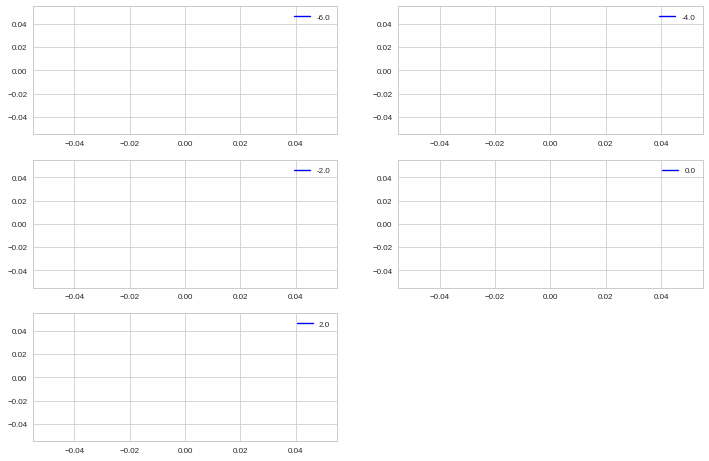

In [26]:
# f = plt.figure(figsize=(12, 8))
# ax = f.add_subplot(1,1,1) 

# sns.swarmplot(x="MLAT", y="normPot", hue="AsyHRnd", data=mlatMLTPotDF[ mlatMLTPotDF["normMLT"] == -2 ],ax=ax)
normMLTList = potDF["normMLT"].unique()[1::2]
print normMLTList
f = plt.figure(figsize=(12, 8))
ax = []
ax.append( f.add_subplot(3,2,1) )
ax.append( f.add_subplot(3,2,2) )
ax.append( f.add_subplot(3,2,3) )
ax.append( f.add_subplot(3,2,4) )
ax.append( f.add_subplot(3,2,5) )
selAsy = 40.
for mind, currMLT in enumerate(normMLTList):
    subDF1 = mlatMLTPotDF[ (mlatMLTPotDF["normMLT"] == currMLT)&\
                              (mlatMLTPotDF["AsyHRnd"] == selAsy) ]
    
    subDF2a = predMlatMLTPotDF[ (predMlatMLTPotDF["predNormMlt"] == currMLT) &\
                              (predMlatMLTPotDF["predAsy"] == selAsy) ]
    ax[mind].plot( subDF2a["predMLAT"].values, subDF2a["predPot"].values, c="b",label=str(currMLT) )
    ax[mind].scatter( subDF1["MLAT"].values, subDF1["normPot"].values, c="b" )
    ax[mind].legend()
#     sns.swarmplot(x="MLAT", y="normPot", hue="AsyHRnd", data=subDF,ax=ax[mind])
#     ax[mind].set_xlim( [52, 65] )
#     ax[mind].set_ylim( [0,1] )

[-6. -4. -2.  0.  2.]


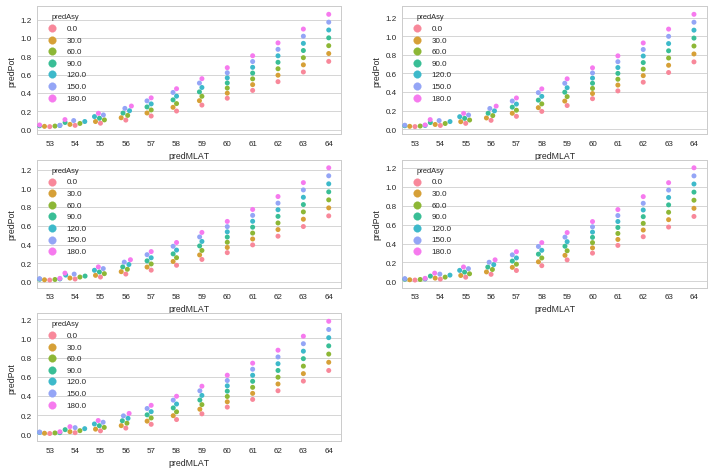

In [27]:
normMLTList = predMlatMLTPotDF["predNormMlt"].unique()[1::2]
print normMLTList
f = plt.figure(figsize=(12, 8))
ax = []
ax.append( f.add_subplot(3,2,1) )
ax.append( f.add_subplot(3,2,2) )
ax.append( f.add_subplot(3,2,3) )
ax.append( f.add_subplot(3,2,4) )
ax.append( f.add_subplot(3,2,5) )
for mind, currMLT in enumerate(normMLTList):
    subDF = predMlatMLTPotDF[ (predMlatMLTPotDF["predNormMlt"] == currMLT) ]
#     subDF.plot( x='MLAT',
#                   y='normPot', c= 'r',ax=ax[mind], kind="scatter", label=str(currMLT))
    sns.swarmplot(x="predMLAT", y="predPot", hue="predAsy", data=subDF,ax=ax[mind])
#     ax[mind].set_xlim( [50,65] )

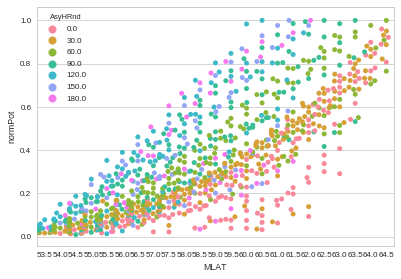

In [28]:
sns.swarmplot(x="MLAT",\
              y="normPot", hue="AsyHRnd", data=mlatMLTPotDF )